In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import pandas as pd


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-05-04 18:04:14.268109: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
df = []
path = '/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr'
it_lim = 10

losses_names = ['H1','L2','W1infty','Linfty','product','psnr']
architectures = ['splines','decreasing','flux']



for var in np.arange(10,55,2.5):
    print(var)
    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=var,var1_u=var,CROP1=CROP,BATCH_SIZE=300,N_REPEAT_FRAME1=1)

    xs, ys = next(gen_batch_val.as_numpy_iterator())
    
    pm = np.array([anisodiff(im,niter = 3,lambd=50) for im in xs])
    pm = np.asarray(pm,dtype='float32')
    
    psnr = tf.reduce_mean(tf.image.psnr(ys,pm,1)).numpy()
    psnr_std = np.std(tf.image.psnr(ys,pm,1).numpy())
    ssim = tf.reduce_mean(tf.image.ssim(ys,pm,1)).numpy()
    ssim_std = np.std(tf.image.ssim(ys,pm,1).numpy())
    
    filling = -np.ones(7)
    df.append(np.concatenate((['pm',var,psnr,psnr_std,ssim,ssim_std,'NA'],filling)))
    
    for N_REPEAT_FRAME1 in np.arange(2,32,2):

            for arch in architectures:
                print(arch)

                for loss in losses_names:
                    print(loss)

                    order = 1
                    for num_classes in [5,10,15,20,25,50]:
                        print('num_classes: ',num_classes)
                        
                        if arch == 'flux' and num_classes >= 50:
                            continue

                        for degree in np.arange(1,6):

                            for f1,factor in enumerate([1]):

                                for use_polynomial in [True,False]:

                                    if use_polynomial:

                                        for polynomial_degree in range(1,3):
                                            
                                            if len(glob(f"{path}/{arch}/checkpoints/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_{it_lim}_t{degree}_{f1}_t{polynomial_degree}*")) > 0:
                                                model = get_model(arch,it_lim=it_lim,image_size=image_size,num_classes = num_classes,
                                                          second=True,degree1=degree,factor=factor)
                                                model.load_weights(f"{path}/{arch}/checkpoints/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_{it_lim}_t{degree}_{f1}_t{polynomial_degree}")
                                                
                                                p = model(xs)
                                                
                                                psnr = tf.reduce_mean(tf.image.psnr(ys,p,1)).numpy()
                                                psnr_std = np.std(tf.image.psnr(ys,p,1).numpy())
                                                ssim = tf.reduce_mean(tf.image.ssim(ys,p,1)).numpy()
                                                ssim_std = np.std(tf.image.ssim(ys,p,1).numpy())
                                                
                                                df.append([arch,var,psnr,psnr_std,ssim,ssim_std,'True',loss,num_classes,N_REPEAT_FRAME1,degree,factor,str(use_polynomial),polynomial_degree])
                                            
                                    else:
                                        if len(glob(f"{path}/{arch}/checkpoints/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_{it_lim}_t{degree}_{f1}_f*"))>0:
                                            
                                            
                                             
                                                
                                            model = get_model(arch,it_lim=it_lim,image_size=image_size,num_classes = num_classes,
                                                      second=True,degree1=degree,factor=factor)
                                            model.load_weights(f"{path}/{arch}/checkpoints/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_{it_lim}_t{degree}_{f1}_f")
                                            
                                            p = model(xs)
                                            
                                            psnr = tf.reduce_mean(tf.image.psnr(ys,p,1)).numpy()
                                            psnr_std = np.std(tf.image.psnr(ys,p,1).numpy())
                                            ssim = tf.reduce_mean(tf.image.ssim(ys,p,1)).numpy()
                                            ssim_std = np.std(tf.image.ssim(ys,p,1).numpy())

                                            df.append([arch,var,psnr,psnr_std,ssim,ssim_std,'True',loss,num_classes,N_REPEAT_FRAME1,degree,factor,str(use_polynomial),-1])

                                            
                        
                        if len(glob(f"{path}/{arch}/checkpoints/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_{it_lim}_f*")) > 0:
                            
                        
                            model = get_model(arch,it_lim=it_lim,image_size=image_size,num_classes = num_classes,second=False)
                            model.load_weights(f"{path}/{arch}/checkpoints/{arch}{loss}_{typ}_{num_classes}_{N_REPEAT_FRAME1}_{it_lim}_f")


                            p = model(xs)

                            psnr = tf.reduce_mean(tf.image.psnr(ys,p,1)).numpy()
                            psnr_std = np.std(tf.image.psnr(ys,p,1).numpy())
                            ssim = tf.reduce_mean(tf.image.ssim(ys,p,1)).numpy()
                            ssim_std = np.std(tf.image.ssim(ys,p,1).numpy())

                            df.append([arch,var,psnr,psnr_std,ssim,ssim_std,'False',loss,num_classes,N_REPEAT_FRAME1,-1,-1,-1,-1])





10.0


2023-04-28 17:14:37.458691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 17:14:37.458909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 17:14:37.464228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 17:14:37.464450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 17:14:37.464629: I tensorflow/compiler/xla/stream_executo

splines
H1
num_classes:  5


2023-04-28 17:14:47.021002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-28 17:15:18.004405: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes: 

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  1

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classe

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_class

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15


num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
15.0
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes: 

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  1

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classe

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_class

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15


num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes: 

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  1

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classe

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_class

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15


num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes: 

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  1

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classe

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_class

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15


num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes: 

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  1

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
37.5
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_class

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classe

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_class

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15


num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes: 

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  1

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classe

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_class

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15


num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes: 

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
flux
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  1

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  

num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
splines
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
W1infty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
Linfty
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
product
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
psnr
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
decreasing
H1
num_classes:  5
num_classes:  10
num_classes:  15
num_classes:  20
num_classes:  25
num_classes:  50
L2
num_classes:  5
num_classes:  10
num_classe

KeyboardInterrupt: 

In [15]:
df = pd.DataFrame(np.array(df),columns=['architecture','variance','psnr','psnr std','ssim','ssim std','second',
                                       'loss','num classes','num repeat','degree','factor','polynomial','polynomial degree'])
df = df.replace('nan',0)
df['variance'] = pd.to_numeric(df['variance'])
df['psnr'] = pd.to_numeric(df['psnr'])
df['psnr std'] = pd.to_numeric(df['psnr std'])
df['ssim'] = pd.to_numeric(df['ssim'])
df['ssim std'] = pd.to_numeric(df['ssim std'])
df['num classes'] = pd.to_numeric(df['num classes'])
df['num repeat'] = pd.to_numeric(df['num repeat'])
df['degree'] = pd.to_numeric(df['degree'])
df['factor'] = pd.to_numeric(df['factor'])
df['polynomial degree'] = pd.to_numeric(df['polynomial degree'])
#df.to_csv('./general_comparison_big.csv')


nn = df[df['architecture'] != 'pm']
df

,architecture,variance,psnr,psnr std,ssim,ssim std,second,loss,num classes,num repeat,degree,factor,polynomial,polynomial degree
0,pm,10.0,31.545715,1.512135,0.881889,0.026082,NA,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,splines,10.0,30.925417,1.854711,0.854960,0.049516,True,H1,5.0,2.0,1.0,1.0,True,1.0
2,splines,10.0,28.072699,5.023682,0.779169,0.177479,True,H1,5.0,2.0,1.0,1.0,True,2.0
3,splines,10.0,31.081562,0.861710,0.815590,0.064510,True,H1,5.0,2.0,1.0,1.0,False,-1.0
4,splines,10.0,31.574312,0.795699,0.832718,0.058930,True,H1,5.0,2.0,2.0,1.0,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98739,decreasing,50.0,23.419243,1.376060,0.602388,0.048515,True,L2,50.0,12.0,2.0,1.0,False,-1.0
98740,decreasing,50.0,23.209457,1.602644,0.587045,0.078789,False,L2,50.0,12.0,-1.0,-1.0,-1,-1.0
98741,decreasing,50.0,23.370290,1.472157,0.610070,0.065843,False,W1infty,5.0,12.0,-1.0,-1.0,-1,-1.0
98742,decreasing,50.0,23.381790,1.453101,0.606597,0.059802,False,W1infty,10.0,12.0,-1.0,-1.0,-1,-1.0


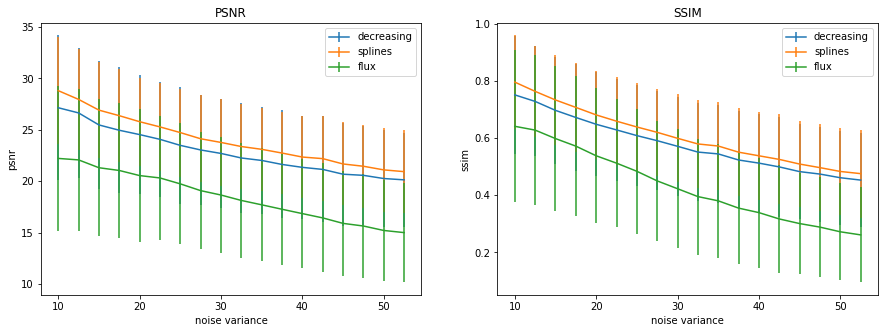

In [176]:
X = nn[nn['psnr']>0].groupby(['architecture','variance']).mean().reset_index()[['architecture','variance','psnr','ssim']].values.T
XS = nn[nn['psnr']>0].groupby(['architecture','variance']).std().reset_index()[['architecture','variance','psnr','ssim']].values.T

archs = ['decreasing','splines','flux']

fig,axs = plt.subplots(ncols=2,figsize=(15,5))

for arch in archs:
    axs[0].errorbar(X[1][X[0]==arch],X[2][X[0]==arch],XS[2][X[0]==arch],label=arch)
    axs[1].errorbar(X[1][X[0]==arch],X[3][X[0]==arch],XS[3][X[0]==arch],label=arch)
    
axs[0].legend()
axs[1].legend()

axs[0].set_title('PSNR')
axs[1].set_title('SSIM')

axs[0].set_xlabel('noise variance')
axs[0].set_ylabel('psnr')

axs[1].set_xlabel('noise variance')
axs[1].set_ylabel('ssim')

plt.show()

In [187]:
index = nn.groupby(['architecture','loss','num repeat','second']).mean().reset_index()[['psnr','architecture','loss','num repeat','second']].values.T
index[:,np.argsort(index[0])[-3]]



array([26.249774833333333, 'splines', 'Linfty', 1.0, 'False'],
      dtype=object)

In [190]:
example_1 = df[(df['architecture']=='splines')&(df['loss']=='psnr')&(df['num repeat']==1)&(df['second']=='False')]
example_2 = df[(df['architecture']=='decreasing')&(df['loss']=='H1')&(df['num repeat']==1)&(df['second']=='False')&
              (df['num classes']==50)]
example_3 = df[(df['architecture']=='splines')&(df['loss']=='Linfty')&(df['num repeat']==1)&(df['second']=='False')&
              (df['num classes']==20)]

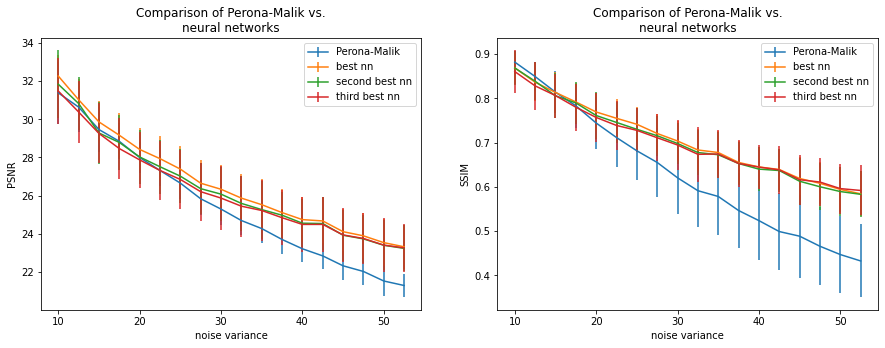

In [200]:

plt.figure(figsize=(15,5))
plt.subplot(121)
x,y,s = df[df['architecture'] == 'pm'][['variance','psnr','psnr std']].values.T
plt.errorbar(x,y,s,label='Perona-Malik')
x,y,s = example_1[['variance','psnr','psnr std']].values.T
plt.errorbar(x,y,s,label='best nn')
x,y,s = example_2[['variance','psnr','psnr std']].values.T
plt.errorbar(x,y,s,label='second best nn')
x,y,s = example_3[['variance','psnr','psnr std']].values.T
plt.errorbar(x,y,s,label='third best nn')
plt.legend()
plt.title('Comparison of Perona-Malik vs.\nneural networks')
plt.xlabel('noise variance')
plt.ylabel('PSNR')
plt.subplot(122)
x,y,s = df[df['architecture'] == 'pm'][['variance','ssim','ssim std']].values.T
plt.errorbar(x,y,s,label='Perona-Malik')
x,y,s = example_1[['variance','ssim','ssim std']].values.T
plt.errorbar(x,y,s,label='best nn')
x,y,s = example_2[['variance','ssim','ssim std']].values.T
plt.errorbar(x,y,s,label='second best nn')
x,y,s = example_3[['variance','ssim','ssim std']].values.T
plt.errorbar(x,y,s,label='third best nn')
plt.legend()
plt.title('Comparison of Perona-Malik vs.\nneural networks')
plt.xlabel('noise variance')
plt.ylabel('SSIM')
plt.show()

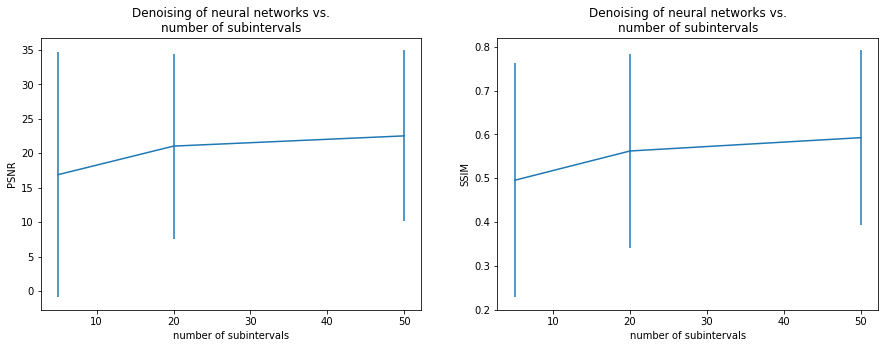

In [201]:
num_classes,psnr,ssim = nn.groupby(['num classes']).mean().reset_index()[['num classes','psnr','ssim']].values.T
psnr_std,ssim_std = nn.groupby(['num classes']).std().reset_index()[['psnr','ssim']].values.T

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.errorbar(num_classes,psnr,psnr_std)
plt.title('Denoising of neural networks vs.\nnumber of subintervals')
plt.xlabel('number of subintervals')
plt.ylabel('PSNR')
plt.subplot(122)
plt.errorbar(num_classes,ssim,ssim_std)
plt.title('Denoising of neural networks vs.\nnumber of subintervals')
plt.xlabel('number of subintervals')
plt.ylabel('SSIM')
plt.show()

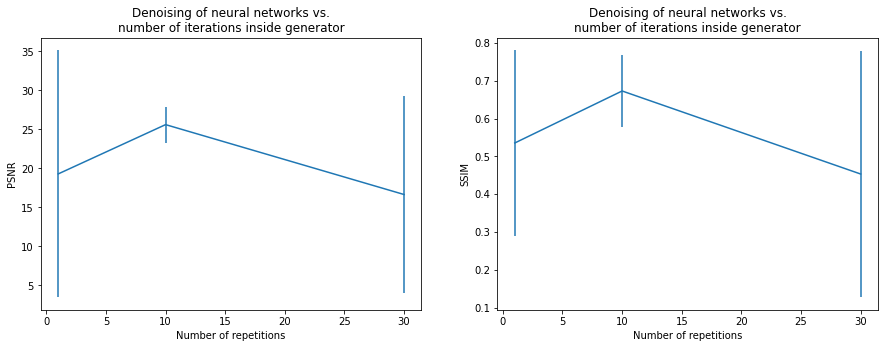

In [203]:
num_repeat,psnr,ssim = nn.groupby(['num repeat']).mean().reset_index()[['num repeat','psnr','ssim']].values.T
psnr_std,ssim_std = nn.groupby(['num repeat']).std().reset_index()[['psnr','ssim']].values.T

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.errorbar(num_repeat,psnr,psnr_std)
plt.title('Denoising of neural networks vs.\nnumber of iterations inside generator')
plt.xlabel('Number of repetitions')
plt.ylabel('PSNR')
plt.subplot(122)
plt.errorbar(num_repeat,ssim,ssim_std)
plt.title('Denoising of neural networks vs.\nnumber of iterations inside generator')
plt.xlabel('Number of repetitions')
plt.ylabel('SSIM')
plt.show()

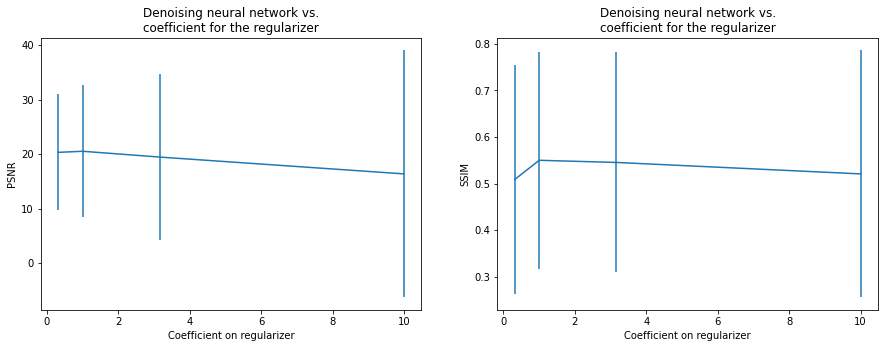

In [204]:
factor,psnr,ssim = nn[nn['factor']>0].groupby(['factor']).mean().reset_index()[['factor','psnr','ssim']].values.T
psnr_std,ssim_std = nn[nn['factor']>0].groupby(['factor']).std().reset_index()[['psnr','ssim']].values.T

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.errorbar(factor,psnr,psnr_std)
plt.title('Denoising neural network vs.\ncoefficient for the regularizer')
plt.xlabel('Coefficient on regularizer')
plt.ylabel('PSNR')
plt.subplot(122)
plt.errorbar(factor,ssim,ssim_std)
plt.title('Denoising neural network vs.\ncoefficient for the regularizer')
plt.xlabel('Coefficient on regularizer')
plt.ylabel('SSIM')
plt.show()

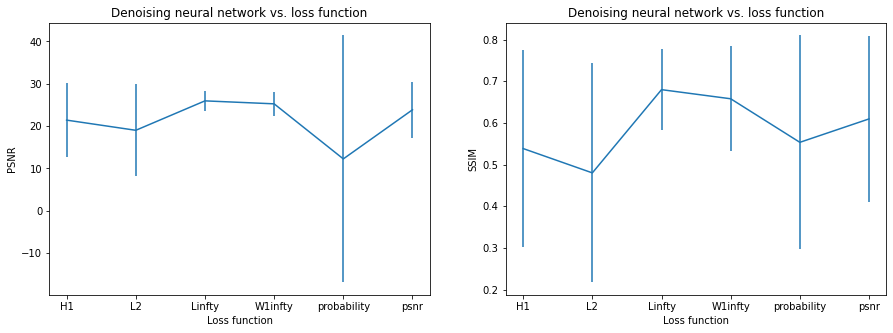

In [209]:
loss,psnr,ssim = nn.groupby(['loss']).mean().reset_index()[['loss','psnr','ssim']].values.T
psnr_std,ssim_std = nn.groupby(['loss']).std().reset_index()[['psnr','ssim']].values.T

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.errorbar(loss,psnr,psnr_std)
plt.title('Denoising neural network vs. loss function')
plt.xlabel('Loss function')
plt.ylabel('PSNR')
plt.subplot(122)
plt.errorbar(loss,ssim,ssim_std)
plt.title('Denoising neural network vs. loss function')
plt.xlabel('Loss function')
plt.ylabel('SSIM')
plt.show()

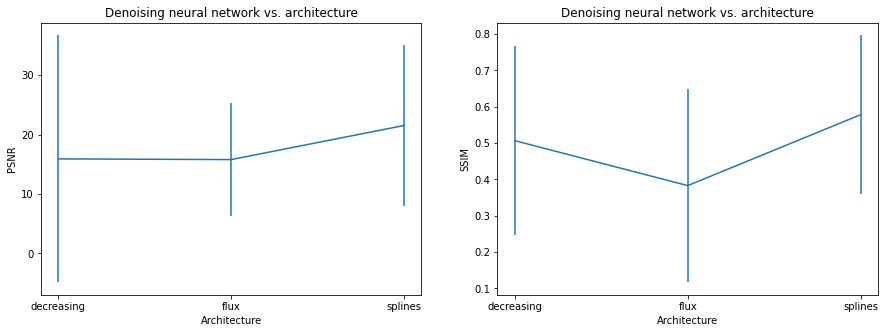

In [211]:
loss,psnr,ssim = nn.groupby(['architecture']).mean().reset_index()[['architecture','psnr','ssim']].values.T
psnr_std,ssim_std = nn.groupby(['architecture']).std().reset_index()[['psnr','ssim']].values.T

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.errorbar(loss,psnr,psnr_std)
plt.title('Denoising neural network vs. architecture')
plt.xlabel('Architecture')
plt.ylabel('PSNR')
plt.subplot(122)
plt.errorbar(loss,ssim,ssim_std)
plt.title('Denoising neural network vs. architecture')
plt.xlabel('Architecture')
plt.ylabel('SSIM')
plt.show()

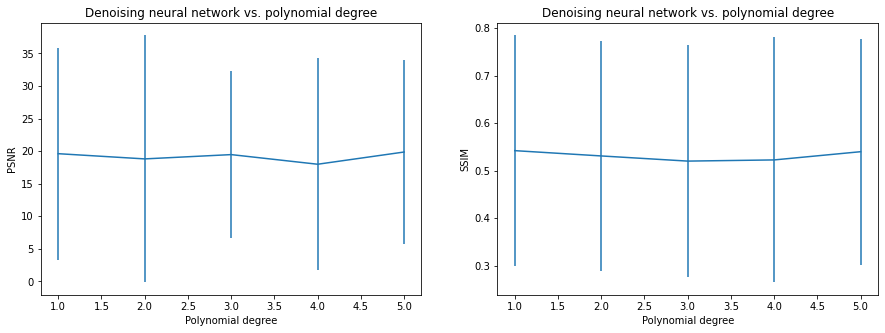

In [213]:
poly_degree,psnr,ssim = nn[nn['polynomial degree']>0].groupby(['polynomial degree']).mean().reset_index()[['polynomial degree','psnr','ssim']].values.T
psnr_std,ssim_std = nn[nn['polynomial degree']>0].groupby(['polynomial degree']).std().reset_index()[['psnr','ssim']].values.T

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.errorbar(poly_degree,psnr,psnr_std)
plt.title('Denoising neural network vs. polynomial degree')
plt.xlabel('Polynomial degree')
plt.ylabel('PSNR')
plt.subplot(122)
plt.errorbar(poly_degree,ssim,ssim_std)
plt.title('Denoising neural network vs. polynomial degree')
plt.xlabel('Polynomial degree')
plt.ylabel('SSIM')
plt.show()

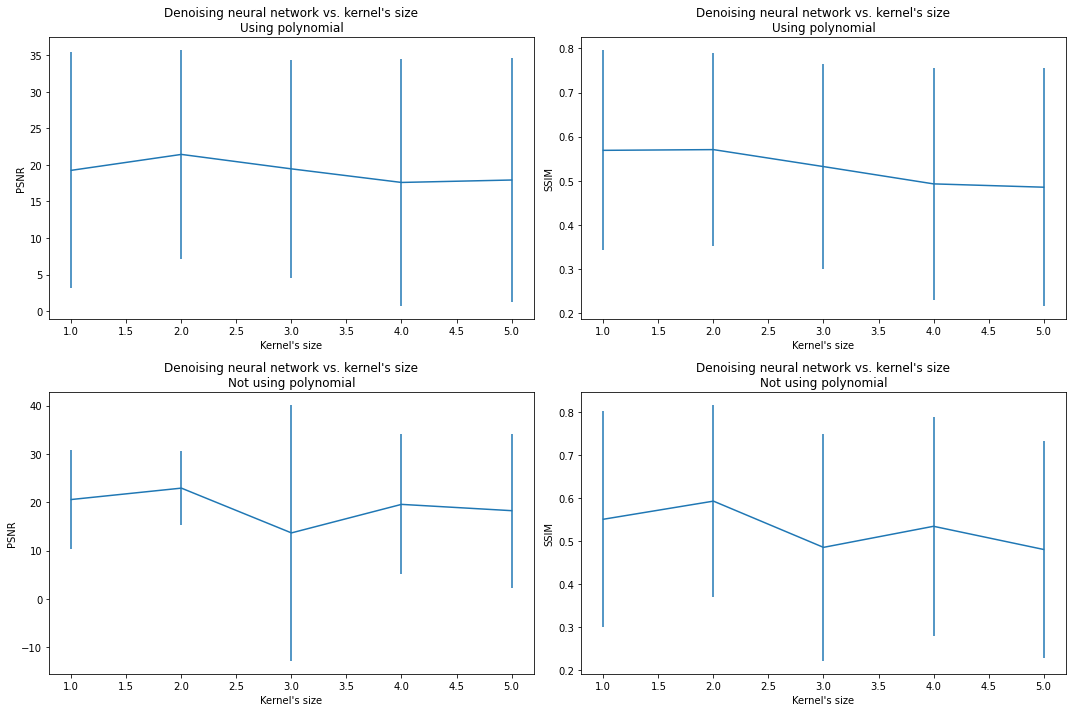

In [216]:
degree,psnr,ssim = nn[(nn['degree']>0)&(nn['polynomial'] == 'True')].groupby(['degree']).mean().reset_index()[['degree','psnr','ssim']].values.T
psnr_std,ssim_std = nn[(nn['degree']>0)&(nn['polynomial'] == 'True')].groupby(['degree']).std().reset_index()[['psnr','ssim']].values.T

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.errorbar(degree,psnr,psnr_std)
plt.title("Denoising neural network vs. kernel's size\nUsing polynomial")
plt.xlabel("Kernel's size")
plt.ylabel('PSNR')
plt.subplot(222)
plt.errorbar(degree,ssim,ssim_std)
plt.title("Denoising neural network vs. kernel's size\nUsing polynomial")
plt.xlabel("Kernel's size")
plt.ylabel('SSIM')

degree,psnr,ssim = nn[(nn['degree']>0)&(nn['polynomial'] != 'True')].groupby(['degree']).mean().reset_index()[['degree','psnr','ssim']].values.T
psnr_std,ssim_std = nn[(nn['degree']>0)&(nn['polynomial'] != 'True')].groupby(['degree']).std().reset_index()[['psnr','ssim']].values.T

plt.subplot(223)
plt.errorbar(degree,psnr,psnr_std)
plt.title("Denoising neural network vs. kernel's size\nNot using polynomial")
plt.xlabel("Kernel's size")
plt.ylabel('PSNR')
plt.subplot(224)
plt.errorbar(degree,ssim,ssim_std)
plt.title("Denoising neural network vs. kernel's size\nNot using polynomial")
plt.xlabel("Kernel's size")
plt.ylabel('SSIM')

plt.tight_layout()
plt.show()